Aluno: Lucas de Almeida Bandeira Macedo

Matrícula: 19/0047089

Este notebook foi construído seguindo o tutorial persente no Medium: [TRAIN A CUSTOM YOLOv4 OBJECT DETECTOR (Using Google Colab)](https://medium.com/p/61a659d4868#a777)

E utiliza a implementação do Yolov4 presente no seguinte repositório: [AlexeyAB/darknet](https://github.com/AlexeyAB/darknet)


## Preprocessamento

In [6]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import re
import cv2
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_dir_list = os.listdir("data")
data_dir_list

['low_abundance',
 'moderate_abundance',
 'super_abundance',
 'test.txt',
 'train.txt',
 'valid.txt']

In [3]:
os.getcwd()

'/mnt/c/Users/lucas/Documents/Programacao/Projeto 2'

In [4]:
d = {"abundance":[], "img_path": [], "label_path": []}
for data_dir in data_dir_list:
  if len(data_dir.split(".")) != 1: continue
  img_file_name_list = os.listdir(f"data/{data_dir}/images")
  lbl_file_name_list = os.listdir(f"data/{data_dir}/annotation")
  for img_path, label_path in zip(sorted(img_file_name_list), sorted(lbl_file_name_list)):
    d["abundance"].append(data_dir)
    d["img_path"].append(f"{os.getcwd()}/data/{data_dir}/images/{img_path}")
    d["label_path"].append(f"{os.getcwd()}/data/{data_dir}/annotation/{label_path}")

df = pd.DataFrame(d)
df

,abundance,img_path,label_path
0,low_abundance,/mnt/c/Users/lucas/Documents/Programacao/Proje...,/mnt/c/Users/lucas/Documents/Programacao/Proje...
1,low_abundance,/mnt/c/Users/lucas/Documents/Programacao/Proje...,/mnt/c/Users/lucas/Documents/Programacao/Proje...
2,low_abundance,/mnt/c/Users/lucas/Documents/Programacao/Proje...,/mnt/c/Users/lucas/Documents/Programacao/Proje...
3,low_abundance,/mnt/c/Users/lucas/Documents/Programacao/Proje...,/mnt/c/Users/lucas/Documents/Programacao/Proje...
4,low_abundance,/mnt/c/Users/lucas/Documents/Programacao/Proje...,/mnt/c/Users/lucas/Documents/Programacao/Proje...
...,...,...,...
2995,super_abundance,/mnt/c/Users/lucas/Documents/Programacao/Proje...,/mnt/c/Users/lucas/Documents/Programacao/Proje...
2996,super_abundance,/mnt/c/Users/lucas/Documents/Programacao/Proje...,/mnt/c/Users/lucas/Documents/Programacao/Proje...
2997,super_abundance,/mnt/c/Users/lucas/Documents/Programacao/Proje...,/mnt/c/Users/lucas/Documents/Programacao/Proje...
2998,super_abundance,/mnt/c/Users/lucas/Documents/Programacao/Proje...,/mnt/c/Users/lucas/Documents/Programacao/Proje...


In [5]:
df_valid = df.sample(frac=0.3, random_state=1)
df_test = df_valid.sample(frac=0.5, random_state=1)

df_train = df.drop(df_valid.index).sample(frac=1)
df_valid = df_valid.drop(df_test.index)

df_train.shape, df_valid.shape, df_test.shape

((2100, 3), (450, 3), (450, 3))

In [6]:
files = ["train", "valid", "test"]
for file, d_df in zip(files, [df_train, df_valid, df_test]):
  f = open(f"data/{file}.txt", "w")
  d_df.img_path.apply(lambda x: f.write(x + "\n") if x.split(".")[-1] == "jpg" else None)


O código na célula a seguir foi extraído do seguinte link:

[https://gist.github.com/Amir22010/a99f18ca19112bc7db0872a36a03a1ec](https://gist.github.com/Amir22010/a99f18ca19112bc7db0872a36a03a1ec)

E adaptado para o contexto do projeto

Seu propósito é fazer a conversão da anotação de XML para TXT, no formato que a yolo da darknet consiga utilizar

In [7]:
import xml.etree.ElementTree as ET

classes = ['whitefly']

def convert(size, box):
  dw = 1./(size[0])
  dh = 1./(size[1])
  x = (box[0] + box[1])/2.0 - 1
  y = (box[2] + box[3])/2.0 - 1
  w = box[1] - box[0]
  h = box[3] - box[2]
  x = x*dw
  w = w*dw
  y = y*dh
  h = h*dh
  return (x,y,w,h)

def convert_annotation(output_path, xml_path):
  in_file = open(xml_path)
  out_file = open(output_path, 'w')
  tree = ET.parse(in_file)
  root = tree.getroot()
  size = root.find('size')
  w = int(size.find('width').text)
  h = int(size.find('height').text)

  for obj in root.iter('object'):
    difficult = obj.find('difficult').text
    cls = obj.find('name').text
    if cls not in classes or int(difficult)==1:
        continue
    cls_id = classes.index(cls)
    xmlbox = obj.find('bndbox')
    b = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text), float(xmlbox.find('ymin').text), float(xmlbox.find('ymax').text))
    bb = convert((w,h), b)
    out_file.write(str(cls_id) + " " + " ".join([str(a) for a in bb]) + '\n')

In [8]:
def a(x):
  out = x.split("/")
  out[-2] = "images"
  name = out[-1].split(".")
  out[-1] = ".".join([name[0], "txt"])
  convert_annotation("/".join(out), x)
  
df.label_path.apply(a)

0       None
1       None
2       None
3       None
4       None
        ... 
2995    None
2996    None
2997    None
2998    None
2999    None
Name: label_path, Length: 3000, dtype: object

## Configurações da Darknet

In [1]:
# f = open("./darknet/Makefile", "r")
# content = f.read()
# f.close()

# content = re.sub(r"GPU=0", "GPU=1", content)
# content = re.sub(r"CUDNN=0", "CUDNN=1", content)
# content = re.sub(r"CUDNN_HALF=0", "CUDNN_HALF=1", content)
# content = re.sub(r"OPENCV=0", "OPENCV=1", content)
# content = re.sub(r"LIBSO=0", "LIBSO=1", content)

# f = open("./darknet/Makefile", "w")
# f.write(content)
# f.close()

%cd darknet/
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

/mnt/c/Users/lucas/Documents/Programacao/Projeto 2/darknet


In [2]:
# !make

chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
  946 |                 float rgb[3];
      |                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
 1147 |             if (iteration_old == 0)
      |

In [3]:
%cd data/
!find -maxdepth 1 -type f -exec rm -rf {} \;
%cd ..

%rm -rf cfg/
%mkdir cfg

%cd ..

/mnt/c/Users/lucas/Documents/Programacao/Projeto 2/darknet/data
/mnt/c/Users/lucas/Documents/Programacao/Projeto 2/darknet
/mnt/c/Users/lucas/Documents/Programacao/Projeto 2


In [4]:
!cp yolov4-custom.cfg darknet/cfg
!cp obj.names darknet/data
!cp obj.data  darknet/data

%cd darknet

/mnt/c/Users/lucas/Documents/Programacao/Projeto 2/darknet


In [5]:
#!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137

In [6]:
!./darknet detector train data/obj.data cfg/yolov4-custom.cfg training/yolov4-custom_last.weights -dont_show -map

 CUDA-version: 11070 (11070), cuDNN: 8.5.0, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 4.2.0
 Prepare additional network for mAP calculation...
 0 : compute_capability = 610, cudnn_half = 0, GPU: NVIDIA GeForce GTX 1060 6GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 64, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    480 x 480 x   3 ->  480 x 480 x  32 0.398 BF
   1 conv     64       3 x 3/ 2    480 x 480 x  32 ->  240 x 240 x  64 2.123 BF
   2 conv     64       1 x 1/ 1    240 x 240 x  64 ->  240 x 240 x  64 0.472 BF
   3 route  1 		                           ->  240 x 240 x  64 
   4 conv     64       1 x 1/ 1    240 x 240 x  64 ->  240 x 240 x  64 0.472 BF
   5 conv     32       1 x 1/ 1    240 x 240 x  64 ->  240 x 240 x  32 0.236 BF
   6 conv     64       3 x 3/ 1    240 x 240 x  32 ->  240 x 240 x  64 2.123 BF
   7 Shortcut La

In [1]:
# %cd darknet

/mnt/c/Users/lucas/Documents/Programacao/Projeto 2/darknet


In [2]:
!cp ../test.cfg cfg/yolov4-custom.cfg

In [3]:
def imShow(path):
  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)
  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

 CUDA-version: 11070 (11070), cuDNN: 8.5.0, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 4.2.0
 0 : compute_capability = 610, cudnn_half = 0, GPU: NVIDIA GeForce GTX 1060 6GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    480 x 480 x   3 ->  480 x 480 x  32 0.398 BF
   1 conv     64       3 x 3/ 2    480 x 480 x  32 ->  240 x 240 x  64 2.123 BF
   2 conv     64       1 x 1/ 1    240 x 240 x  64 ->  240 x 240 x  64 0.472 BF
   3 route  1 		                           ->  240 x 240 x  64 
   4 conv     64       1 x 1/ 1    240 x 240 x  64 ->  240 x 240 x  64 0.472 BF
   5 conv     32       1 x 1/ 1    240 x 240 x  64 ->  240 x 240 x  32 0.236 BF
   6 conv     64       3 x 3/ 1    240 x 240 x  32 ->  240 x 240 x  64 2.123 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 240 x 240 x  64 0.

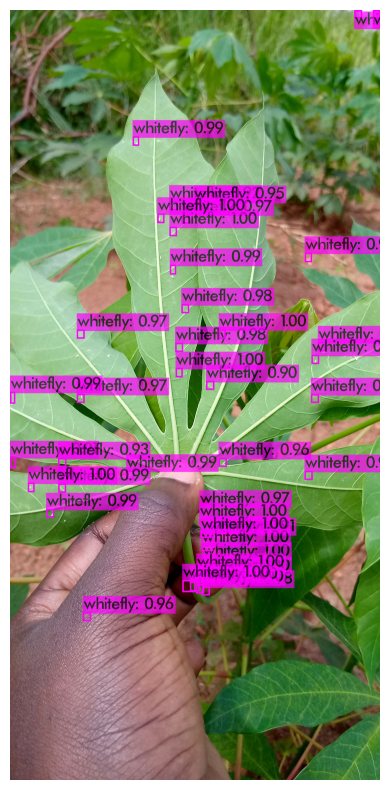

In [15]:
!./darknet detector test data/obj.data cfg/yolov4-custom.cfg training/yolov4-custom_last.weights ../data/moderate_abundance/images/IMG_20190218_232306_1.jpg -thresh 0.9
imShow('predictions.jpg')